In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

from PIL import Image
import matplotlib
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
matplotlib.rc('figure', figsize=(12, 5))

In [8]:
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

use_cuda

True

## Load images

In [9]:
imsize = 512 if use_cuda else 128

loader = transforms.Compose([
    transforms.Scale(imsize), # scale image
    transforms.ToTensor()     # transform to torch tensor
    # Note: PIL image values are (0-255)
    # PIL -> Tensor values are (0-1)
])

def img_loader(img_name):
    img = Image.open(img_name)
    img = Variable(loader(img))
    
    # add batch dimension
    img = img.unsqueeze(0)
    return img

style_img = img_loader('data/neural-style/picasso.jpg').type(dtype)
content_img = img_loader('data/neural-style/dancing.jpg').type(dtype)

# assert both images have the same size
assert style_img.size() == content_img.size()

## Display images

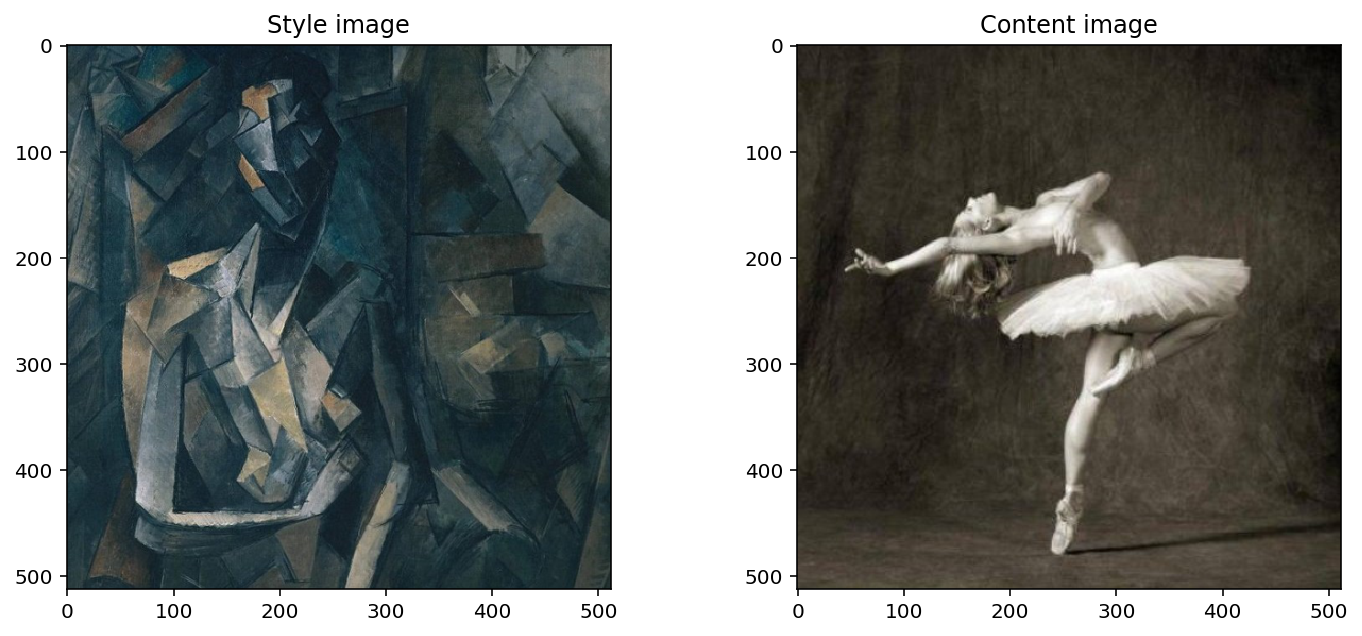

In [4]:
to_pil = transforms.ToPILImage() # convert back to PIL image

plt.ion()

def imshow(tensor):
    img = tensor.clone().cpu()
    img = img.view(3, imsize, imsize) # rgb, width, height
    img = to_pil(img)
    plt.imshow(img)

ax = plt.subplot(1,2,1)
imshow(style_img.data)
ax.set_title("Style image")

ax = plt.subplot(1,2,2)
imshow(content_img.data)
ax.set_title("Content image")

plt.show()

## Style and content losses

We not only want to calculate the loss between the final neural network prediction and target but want to compute the loss **at every layer**. We keep these losses as we train the network.

In [1]:
class ContentLoss(nn.Module):
    
    def __init__(self, target, weight):
        super(ContentLoss, self).__init__()
        
        # detach the target from the graph
        self.target = target.detach() * weight
        self.weight = weight
        self.criterion = nn.MSELoss() # loss function
    
    def forward(self, inputs):
        
        # compute loss between target image and prediction
        self.loss = self.criterion(inputs * self.weight, self.target)
        
        # carry forward the original input
        self.output = inputs
        return self.output
    
    def backward(self, retain_variables=True):
        self.loss.backward(retain_variables=retain_variables)
        
        # carry backward the loss
        return self.loss

NameError: name 'nn' is not defined

In [ ]:
class GramMatrix(nn.Module):
    
    def forward(self, inputs):
        batch_size, num_feature_maps, fmap_x, fmap_y = inputs.size()
        
        # flatten input image into 2D matrix
        features = inputs.view(
            batch_size * num_feature_maps,
            fmap_x * fmap_y)
        
        # calculate Gram matrix (X * X.T)
        G = torch.mm(features, features.t())
        
        # normalise
        return G.div(batch_size * num_feature_maps * fmap_x * fmap_y)

In [ ]:
class StyleLoss(nn.Module):
    
    def __init__(self, target, weight):
        super(StyleLoss, self).__init__()
        
        self.target = target.detach() * weight
        self.weight = weight
        self.gram = GramMatrix()
        self.criterion = nn.MSELoss()
    
    def forward(self, inputs):
        self.output = inputs.clone()
        self.G = self.gram(inputs)
        self.G.mul_(self.weight)
        self.loss = self.criterion(self.G, self.target)
        return self.output
    
    def backward(self, retain_variables=True):
        self.loss.backward(retain_variables=retain_variables)
        return self.loss

## Load pretrained model

The VGG19 neural network has 19 layers. The layers are split into 2 groups: features (convolutional and pooling layer) and classifier (fully connected layers).

We want to slot in our 'transparent' content and style loss modules/layers within the VGG network.

In [5]:
cnn = models.vgg19(pretrained=True).features

# if use_cuda:
#     cnn = cnn.cuda()

In [6]:
cnn

Sequential (
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU (inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU (inplace)
  (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU (inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU (inplace)
  (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU (inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU (inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU (inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU (inplace)
  (18): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (19): Conv2d(256,

In [ ]:
# desired layers to slot in / compute our content and style losses
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(
    cnn,
    style_img,
    content_img,
    style_weight=1000,
    content_weight=1,
    content_layers=content_layers_default,
    style_layers=style_layers_default):
    
    cnn = copy.deepcopy(cnn)
    
    # save losses at each loss layer
    content_losses = []
    style_losses = []
    
    # create a new model to replace VGG
    model = nn.Sequential()
    gram = GramMatrix()
    
    if use_cuda:
        model = model.cuda()
        gram = gram.cuda()
    
    i = 1
    for layer in list(cnn):
        
        if isinstance(layer, nn.Conv2d):
            name = 'conv_' + str(i)
            model.add_module(name, layer)
            
            if name in content_layers:
                # add content loss layer
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module('content_loss_' + str(i), content_loss)
                content_losses.append(content_loss)
            
            if name in style_layers:
                # add style loss layer
                target = model(style_img).clone()
                target = gram(target)
                style_loss = StyleLoss(target, style_weight)
                model.add_module('style_loss_' + str(i), style_loss)
                style_losses.append(style_loss)
            
        if isinstance(layer, nn.ReLU):
            name = 'relu_' + str(i)
            model.add_module(name, layer)
            
            if name in content_layers:
                # add content loss layer
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module('content_loss_' + str(i), content_loss)
                content_losses.append(content_loss)
            
            if name in style_layers:
                # add style loss layer
                target = model(style_img).clone()
                target = gram(target)
                style_loss = StyleLoss(target, style_weight)
                model.add_module('style_loss_' + str(i), style_loss)
                style_losses.append(style_loss)
            
            i += 1
        
        if isinstance(layer, nn.MaxPool2d):
            name = 'pool_' + str(i)
            model.add_module(name, layer)
    
    return model, style_losses, content_losses

In [ ]:
# use content image as input image
input_img = content_img.clone()

# or use random noise image as input img
# input_img = Variable(torch.randn(content_img.data.size())).type(dtype)

plt.figure()
imshow(input_img.data)
plt.title('Input image');

## Define optimiser

Optimisers expect tensor variables that can be differentiated (a gradient can be calculated). We are trying to optimise the loss between two image tensors but because they are not leaves of the computation graph, their gradients cannot be calculated. We want to calculate their gradients so we use Parameter instead of Variable here.

Instead of tweaking the weights of a neural network, we are tweaking the pixel values of an (random) input image.

In [ ]:
def get_input_param_optimiser(input_img):
    param = nn.Parameter(input_img.data)
    optimiser = optim.LBFGS([param])
    return param, optimiser

In [ ]:
def run_style_transfer(
    cnn,
    content_img,
    style_img,
    input_img,
    num_steps=300,
    style_weight=1e3,
    content_weight=0.3):
    
    print('Building style transfer model ...')
    
    model, style_losses, content_losses = get_style_model_and_losses(
        cnn,
        style_img,
        content_img,
        style_weight,
        content_weight)
    
    input_param, optimiser = get_input_param_optimiser(input_img)
    
    print('Optimising ...')
    
    run = [0]
    while run[0] <= num_steps:
        
        def closure():
            
            # clamp values between 0 and 1
            input_param.data.clamp_(0, 1)
            
            optimiser.zero_grad()
            model(input_param)
            
            style_score = 0
            content_score = 0
            
            for loss in style_losses:
                style_score += loss.backward()
            for loss in content_losses:
                content_score += loss.backward()
            
            run[0] += 1
            if run[0] % 50 == 0:
                print('Run: {}'.format(run))
                print('Style loss: {:4f} Content loss: {:4f}'.format(
                      style_score.data[0], content_score.data[0]))
                print()
            
            return style_score + content_score
        
        optimiser.step(closure)
    
    # last clamp
    input_param.data.clamp_(0, 1)
    
    return input_param.data

## Run

In [ ]:
output = run_style_transfer(cnn, content_img, style_img, input_img)

In [ ]:
plt.figure(figsize=(8, 8))
imshow(output)
plt.title('Output image')
plt.ioff()
plt.show()